![digitizing_team](digitizing_team.png)


DigiNsure Inc. is an innovative insurance company focused on enhancing the efficiency of processing claims and customer service interactions. Their newest initiative is digitizing all historical insurance claim documents, which includes improving the labeling of some IDs scanned from paper documents and identifying them as primary or secondary IDs.

To help them in their effort, you'll be using multi-modal learning to train an Optical Character Recognition (OCR) model. To improve the classification, the model will use **images** of the scanned documents as input and their **insurance type** (home, life, auto, health, or other). Integrating different data modalities (such as image and text) enables the model to perform better in complex scenarios, helping to capture more nuanced information. The **labels** that the model will be trained to identify are of two types: a primary and a secondary ID, for each image-insurance type pair.

In [54]:
! pip install torchvision

Defaulting to user installation because normal site-packages is not writeable


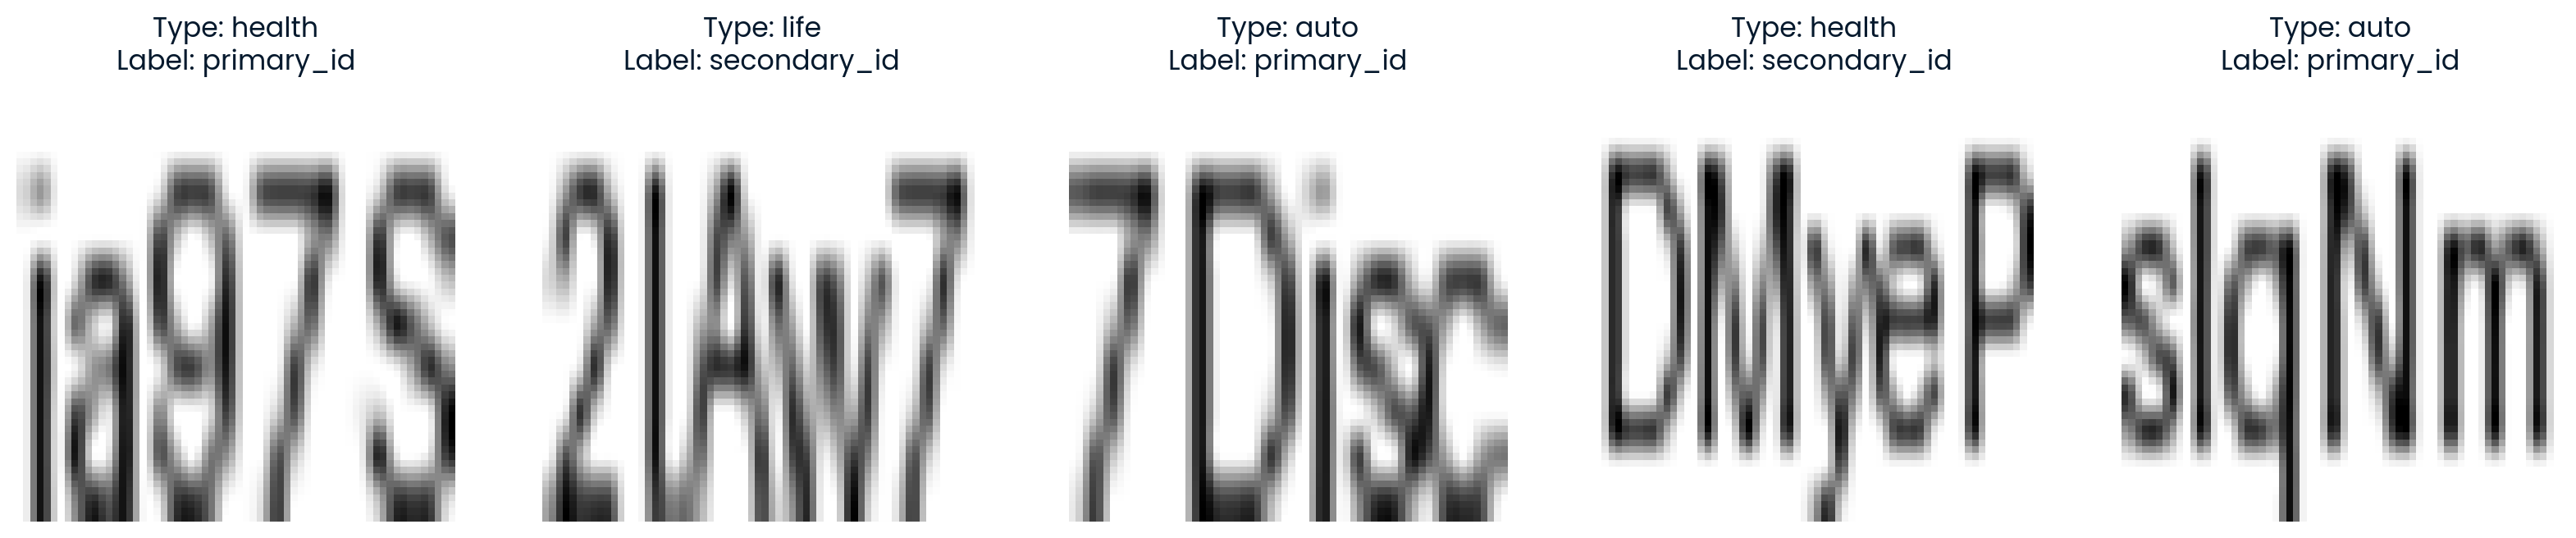

((tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.8824, 0.7804, 0.7373],
         [1.0000, 1.0000, 1.0000,  ..., 0.9176, 0.7961, 0.7451],
         [1.0000, 1.0000, 1.0000,  ..., 0.9373, 0.8039, 0.7451]]]), tensor([1., 0., 0., 0., 0.])), 0)


In [55]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from project_utils import ProjectDataset
import pickle 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Load the data
dataset = pickle.load(open('ocr_insurance_dataset.pkl', 'rb'))

# Define a function to visualize codes with their corresponding types and labels 
def show_dataset_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, min(num_images, len(dataset)), figsize=(20, 4))
    for ax, idx in zip(axes, np.random.choice(len(dataset), min(num_images, len(dataset)), False)):
        img, lbl = dataset[idx]
        ax.imshow((img[0].numpy() * 255).astype(np.uint8).reshape(64,64), cmap='gray'), ax.axis('off')
        ax.set_title(f"Type: {list(dataset.type_mapping.keys())[img[1].tolist().index(1)]}\nLabel: {list(dataset.label_mapping.keys())[list(dataset.label_mapping.values()).index(lbl)]}")
    plt.show()

# Inspect 5 codes images from the dataset
show_dataset_images(dataset)
print(dataset[0])

In [56]:
from torch.utils.data import Dataset

class InsuranceDataset(Dataset):
    def __init__(self, data):
        self.data = data 
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Retrieve the data sample at the specified index
        (image_tensor, type_tensor), label_int = self.data[idx]
        
        return image_tensor, type_tensor, label_int


insurance_dataset = InsuranceDataset(dataset)

dataloader = DataLoader(insurance_dataset, batch_size=2, shuffle=True)
print(dataloader)

In [57]:
import torch.nn.functional as F

class OCRModel(nn.Module):
    def __init__(self):
        super(OCRModel, self).__init__()
        
        # Define the image layer 
        self.image_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Pooling layer to reduce the spatial dim
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()  # Flatten the output for the fully connected layer
        )
        
        # Fully connected layer for image features
        # After two 2x2 poolings on a 64x64 input, the output size is 16x16
        self.fc_image = nn.Linear(32 * 16 * 16, 128)  # 32 output channels, 16x16 feature map
        
        # Define type processing layer (fully connected layer)
        self.fc_type = nn.Linear(5, 64)  # Assuming 5 possible insurance types

        # Define the final classifier layer for prediction
        self.fc_combined = nn.Linear(128 + 64, 5)  # Combine image and type features

    def forward(self, image, insurance_type):
        # Image layer: pass the image through the sequential module
        x = self.image_layer(image)
        
        # Pass through the fully connected layer for image
        x = F.relu(self.fc_image(x))
        
        # Type layer: fully connected layer for insurance type
        type_out = F.relu(self.fc_type(insurance_type))
        
        # Concatenate image features and type features
        combined = torch.cat((x, type_out), dim=1)
        
        # Pass through the final classifier layer
        out = self.fc_combined(combined)
        
        return out

In [58]:
import torch.optim as optim

# Instantiate the model
model = OCRModel()

# Define the optimizer (Adam) with a learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

In [59]:
def train_model(model, dataloader, optimizer, criterion, num_epochs=2):
    model.train()  # Set model to training mode
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        # Iterate over batches
        for i, (images, types, targets) in enumerate(dataloader):
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images, types)
            
            # Compute loss
            loss = criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            # Accumulate loss for monitoring
            running_loss += loss.item()
            
            # Print statistics every 10 batches
            if (i + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {running_loss / 10:.4f}")
                running_loss = 0.0

    print("Training completed.")

# Train the model
train_model(model, dataloader, optimizer, criterion, num_epochs=10)

Epoch [1/10], Step [10/50], Loss: 0.9849
Epoch [1/10], Step [20/50], Loss: 0.8126
Epoch [1/10], Step [30/50], Loss: 0.8122
Epoch [1/10], Step [40/50], Loss: 0.7979
Epoch [1/10], Step [50/50], Loss: 0.8678
Epoch [2/10], Step [10/50], Loss: 0.8014
Epoch [2/10], Step [20/50], Loss: 0.5293
Epoch [2/10], Step [30/50], Loss: 0.9911
Epoch [2/10], Step [40/50], Loss: 0.7386
Epoch [2/10], Step [50/50], Loss: 0.6879
Epoch [3/10], Step [10/50], Loss: 0.7361
Epoch [3/10], Step [20/50], Loss: 0.6930
Epoch [3/10], Step [30/50], Loss: 0.7911
Epoch [3/10], Step [40/50], Loss: 0.7140
Epoch [3/10], Step [50/50], Loss: 0.6839
Epoch [4/10], Step [10/50], Loss: 0.7022
Epoch [4/10], Step [20/50], Loss: 0.6258
Epoch [4/10], Step [30/50], Loss: 0.7363
Epoch [4/10], Step [40/50], Loss: 0.7196
Epoch [4/10], Step [50/50], Loss: 0.6643
Epoch [5/10], Step [10/50], Loss: 0.6707
Epoch [5/10], Step [20/50], Loss: 0.6450
Epoch [5/10], Step [30/50], Loss: 0.6467
Epoch [5/10], Step [40/50], Loss: 0.7071
Epoch [5/10], St